## Hackathon Forecast Big Data 2025

### Previsão de Reposição de Produtos com Machine Learning

desenvolver um modelo de previsão de vendas (forecast) para apoiar o varejo na reposição de produtos. A tarefa é prever a quantidade semanal de vendas por PDV (Ponto de Venda) /SKU Stock Keeping Unit (ou Unidade de Manutenção de Estoque) para as cinco semanas de janeiro/2023, utilizando como base o histórico de vendas de 2022.

##### Esse é um problema real, baseado no nosso produto One-Click Order.

In [1]:
# Bibliotecas principais

import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from glob import glob
from datetime import datetime
from packaging import version

from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# Outlier & clustering
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN, KMeans

# ML
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor
import torch

# Pipeline
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

In [3]:
df_pdv = pd.read_parquet("../data/raw/part-00000-tid-2779033056155408584-f6316110-4c9a-4061-ae48-69b77c7c8c36-4-1-c000.snappy.parquet")     
df_prod  = pd.read_parquet("../data/raw/part-00000-tid-7173294866425216458-eae53fbf-d19e-4130-ba74-78f96b9675f1-4-1-c000.snappy.parquet")   
df_trans = pd.read_parquet("../data/raw/part-00000-tid-5196563791502273604-c90d3a24-52f2-4955-b4ec-fb143aae74d8-4-1-c000.snappy.parquet") 

In [4]:
# Verificando estrutura e colunas da transação
print("Info - Colunas e tipos em df_pdv:")
print(df_pdv.dtypes)

print("\nInfo - Nulos por coluna:")
print(df_pdv.isnull().sum())

print("\n10 primeiras linhas - Dataframe:")
df_pdv.head(10)

Info - Colunas e tipos em df_pdv:
pdv              object
premise          object
categoria_pdv    object
zipcode           int32
dtype: object

Info - Nulos por coluna:
pdv              0
premise          0
categoria_pdv    0
zipcode          0
dtype: int64

10 primeiras linhas - Dataframe:


,pdv,premise,categoria_pdv,zipcode
0,2204965430669363375,On Premise,Mexican Rest,30741
1,5211957289528622910,On Premise,Hotel/Motel,80011
2,9024493554530757353,Off Premise,Convenience,80751
3,8659197371382902429,On Premise,Restaurant,80439
4,1400854873763881130,On Premise,Restaurant,30093
5,6067948396569964814,Off Premise,Grocery,80906
6,5450209638302911403,Off Premise,Convenience,30721
7,691022780643224115,On Premise,Other On Premise,80205
8,678360571217951483,On Premise,Restaurant,80233
9,7389100204865028460,Off Premise,Package/Liquor,80204


In [5]:
# Verificando estrutura e colunas de produto
print("Info - Colunas e tipos em df_prod:")
print(df_prod.dtypes)

print("\nInfo - Nulos por coluna:")
print(df_prod.isnull().sum())

print("\n10 primeiras linhas - Dataframe:")
df_prod.head(10)

Info - Colunas e tipos em df_prod:
produto         object
categoria       object
descricao       object
tipos           object
label           object
subcategoria    object
marca           object
fabricante      object
dtype: object

Info - Nulos por coluna:
produto            0
categoria          0
descricao          0
tipos              0
label           1473
subcategoria      32
marca              0
fabricante         0
dtype: int64

10 primeiras linhas - Dataframe:


,produto,categoria,descricao,tipos,label,subcategoria,marca,fabricante
0,2282334733936076502,Distilled Spirits,JOSEPH CARTRON CAFÉ LIQUEUR,Distilled Spirits,Core,Liqueurs & Cordials,Joseph Cartron Cafe,Spiribam
1,6091840953834683482,Distilled Spirits,SPRINGBANK 18 YEAR SINGLE MALT 700ML,Distilled Spirits,Specialty,Scotch Whisky,Springbank 18 Year Single Malt,Pacific Edge Wine & Spirits
2,1968645851245092408,Distilled Spirits,J BRANDT TRIPLE SEC 12/750ML 30PF,Distilled Spirits,Private Label,Liqueurs & Cordials,J Brandt Triple Sec,Sazerac Spirits
3,994706710729219179,Draft,REFORMATION CASHMERE IPA 1/4 KEG,Draft,In&Out,Other Draft,Reformation Cashmere Fresh Hop IPA,Reformation Brewery
4,9209550539540384349,Non-Alcohol,HELLA MOSCOW MULE 750ML,Non Alcohol,Core,Mixers,Hella Bitters Bloody Mary,Hella Bitter Llc
5,1466206072929919887,Distilled Spirits,GRANNY'S GINGERBREAD CREAM 25 PROOF 750ML,Distilled Spirits,In&Out,Liqueurs & Cordials,Sazerac Granny's Gingerbread Cream,Sazerac ABA
6,405158664555012743,Package,BOLD ROCK INDIA PRESSED APPLE 6/4/16 CAN,Package,Core,Other Package,Bold Rock India Pressed Apple Hard Cider,Bold Rock Hard Cider
7,6040677600408757429,Distilled Spirits,FRIS VODKA 12/10/50ML 80PF,Allocated Spirits,None,Vodka,Fris Vodka,Sazerac Spirits
8,6028082604838966860,Distilled Spirits,TESSORA CREMA AL LIMONE 750ML,Distilled Spirits,Core,Liqueurs & Cordials,Tessora Crema Al Limone,Veriano Fine Food & Spirits
9,1165416298911477885,Distilled Spirits,THE CLUB CAPE COD 24/200ML CN 30PF,Distilled Spirits,None,Ready-to-Drink,The Club Pina Colada RTD,Sazerac Spirits


In [6]:
# Verificando estrutura e colunas da transação
print("Info - Colunas e tipos em df_trans:")
print(df_trans.dtypes)

print("\nInfo - Nulos por coluna:")
print(df_trans.isnull().sum())

print("\n10 primeiras linhas - Dataframe:")
df_trans.head(10)

Info - Colunas e tipos em df_trans:
internal_store_id       object
internal_product_id     object
distributor_id          object
transaction_date        object
reference_date          object
quantity               float64
gross_value            float64
net_value              float64
gross_profit           float64
discount               float64
taxes                  float64
dtype: object

Info - Nulos por coluna:
internal_store_id      0
internal_product_id    0
distributor_id         0
transaction_date       0
reference_date         0
quantity               0
gross_value            0
net_value              0
gross_profit           0
discount               0
taxes                  0
dtype: int64

10 primeiras linhas - Dataframe:


,internal_store_id,internal_product_id,distributor_id,transaction_date,reference_date,quantity,gross_value,net_value,gross_profit,discount,taxes
0,7384367747233276219,328903483604537190,9,2022-07-13,2022-07-01,1.00000,38.125000,37.890625,10.042625,3.950000,0.234375
1,3536908514005606262,5418855670645487653,5,2022-03-21,2022-03-01,6.00000,107.250000,106.440002,24.732002,17.100000,0.810000
2,3138231730993449825,1087005562675741887,6,2022-09-06,2022-09-01,3.00000,56.625000,56.220001,14.124002,5.250000,0.405000
3,3681167389484217654,1401422983880045188,5,2022-09-11,2022-09-01,129.00000,1037.160023,1037.160023,156.348026,479.880006,0.000000
4,7762413312337359369,6614994347738381720,4,2022-02-18,2022-02-01,1.00000,26.230000,23.950241,6.550241,0.000000,2.279758
5,5871504315270136638,3553055402616033444,10,2022-09-11,2022-09-01,48.00000,239.520004,239.520004,37.839989,47.040001,0.000000
6,1027356552181929439,576514643033029430,4,2022-10-04,2022-10-01,7.00000,153.754997,133.807114,40.518112,23.450000,19.947886
7,6652651222667566690,2811937796518769916,5,2022-09-11,2022-09-01,45.99999,2035.279598,2035.279598,517.279939,123.639971,0.000000
8,7752780566579715772,5418855670645487653,4,2022-06-21,2022-06-01,12.00000,223.703999,203.186169,54.818170,15.600000,20.517828
9,5339226423887032797,2126695985526201979,5,2022-10-06,2022-10-01,1.00000,42.799999,42.619999,12.772999,6.180000,0.180000


In [5]:
def prep_and_merge(df_trans, df_prod, df_pdv):
    # padroniza headers
    for d in (df_trans, df_prod, df_pdv):
        d.columns = d.columns.str.lower().str.strip()

    # renomeia chaves se necessário
    if 'produto' not in df_trans and 'internal_product_id' in df_trans:
        df_trans = df_trans.rename(columns={'internal_product_id':'produto'})
    if 'pdv' not in df_trans and 'internal_store_id' in df_trans:
        df_trans = df_trans.rename(columns={'internal_store_id':'pdv'})
    if 'produto' not in df_prod and 'product' in df_prod:
        df_prod = df_prod.rename(columns={'product':'produto'})
    if 'pdv' not in df_pdv and 'store_id' in df_pdv:
        df_pdv = df_pdv.rename(columns={'store_id':'pdv'})

    # checagem clara
    req = {'produto','pdv'}
    miss = req - set(df_trans.columns)
    if miss: raise KeyError(f"df_trans sem colunas: {miss}")

    # normalização das chaves e merge
    def norm_id(s):
        return (s.astype(str).str.strip()
                 .str.replace(r'[^0-9]','',regex=True)
                 .str.lstrip('0'))

    df_trans['_join_key'] = norm_id(df_trans['produto'])
    df_prod ['_join_key'] = norm_id(df_prod['produto'])
    df_trans['_join_pdv'] = norm_id(df_trans['pdv'])
    df_pdv  ['_join_pdv'] = norm_id(df_pdv['pdv'])

    df_prod = df_prod.drop_duplicates('_join_key', keep='last')
    df_pdv  = df_pdv.drop_duplicates('_join_pdv', keep='last')

    df_merge = (df_trans
                .merge(df_prod, on='_join_key', how='left', suffixes=('','_prod'))
                .merge(df_pdv,  on='_join_pdv', how='left', suffixes=('','_pdv')))

    miss_prod = df_merge.filter(regex='_prod$').isna().all(1).mean()
    miss_pdv  = df_merge.filter(regex='_pdv$').isna().all(1).mean()
    print(f"sem match PROD: {miss_prod:.3%} | sem match PDV: {miss_pdv:.3%}")

    return df_merge

# uso
df_merge = prep_and_merge(df_trans, df_prod, df_pdv)

sem match PROD: 0.000% | sem match PDV: 0.000%


In [6]:
# sanity check e criação da iso week

df_merge.drop(columns=[c for c in ['_join_key','_join_pdv','pdv_pdv'] if c in df_merge], inplace=True)
num = ['quantity','gross_value','net_value','gross_profit','discount','taxes']
df_merge[num] = df_merge[num].apply(pd.to_numeric, errors='coerce').astype('float32')
df_merge['transaction_date'] = pd.to_datetime(df_merge['transaction_date'], errors='coerce')
iso = df_merge['transaction_date'].dt.isocalendar()
df_merge['iso_year'] = iso.year.astype('int32'); df_merge['iso_week'] = iso.week.astype('int16')

### Regra para anomalias semanais - 2022

**Entrada**: `weekly` agregado por `premise, pdv, produto, iso_year, iso_week` com `quantity, gross_value, gross_profit`.  
**Saída**: tabela `premise, iso_week, anomaly_flag`. Nada é removido; só será marcado.

**Por quê**: picos/quedas distorcem *lags/rollings* e criam over/underforecast. A estatística é útil para sinalizar ruído.

**Critérios (será marcado se qualquer regra acionar):**
1. **Z-robusto** por canal e por escopo global:  
   \( z(x)=\frac{x-\text{mediana}}{1.4826\cdot \text{MAD}} \).  
   Flag se **≥2** métricas entre `quantity, gross_value, gross_profit` tiverem \(|z|>4\).
2. **Salto + compensação**: variação semanal \(|\Delta\%|>150\%\) com inversão de sinal na semana seguinte.
3. **Concentração atípica**: `share_qty` da semana > **6%** do ano.

**Uso no pipeline**:
- Não excluímos linhas.  
- Ao criar *lags/rollings*, semanas com `anomaly_flag=True` são **mascaradas** (definidas como `NaN`) apenas nas features.  
- O target original foi mantido e foi escolhido o tratamento que **reduz WMAPE** no holdout (W48–W52/2022).

**Limites**: se MAD=0 (série quase constante) o z-robusto vira 0; eventos reais podem ser marcados, mas a máscara evita contaminar os *lags*.

In [8]:
def mark_week_anomalies(weekly, year=2022, z_thr=4.0, pct_thr=1.5, share_thr=0.06):
    def robust_z(x):
        m = x.median(); mad = (x-m).abs().median()
        if mad == 0: return pd.Series(0.0, index=x.index)
        return (x-m) / (1.4826*mad)

    wk = weekly.query('iso_year == @year').copy()
    out = []
    for scope in ['premise','GLOBAL']:
        if scope == 'premise':
            grp = wk.groupby(['premise','iso_week'], as_index=False)[['quantity','gross_value','gross_profit']].sum()
        else:
            grp = wk.groupby(['iso_week'], as_index=False)[['quantity','gross_value','gross_profit']].sum()
            grp['premise'] = 'GLOBAL'; grp = grp[['premise','iso_week','quantity','gross_value','gross_profit']]

        grp['z_qty'] = grp.groupby('premise')['quantity'].transform(robust_z)
        grp['z_gv']  = grp.groupby('premise')['gross_value'].transform(robust_z)
        grp['z_gp']  = grp.groupby('premise')['gross_profit'].transform(robust_z)
        grp['share_qty'] = grp['quantity'] / grp.groupby('premise')['quantity'].transform('sum')
        grp['pct_change'] = grp.groupby('premise')['quantity'].pct_change()
        next_ch = grp.groupby('premise')['pct_change'].shift(-1)
        grp['rebound'] = grp['pct_change'].abs().ge(pct_thr) & (grp['pct_change']*next_ch < 0)

        k = (grp[['z_qty','z_gv','z_gp']].abs() > z_thr).sum(axis=1) >= 2
        grp['anomaly_flag'] = k | (grp['share_qty'] > share_thr) | grp['rebound']
        out.append(grp[['premise','iso_week','anomaly_flag']])

    return pd.concat(out, ignore_index=True)

In [9]:
# weekly (sem filtro)
weekly = (df_merge.groupby(['premise','pdv','produto','iso_year','iso_week'],
                           observed=True, sort=False, as_index=False)
          .agg(quantity=('quantity','sum'),
               gross_value=('gross_value','sum'),
               gross_profit=('gross_profit','sum')))

In [10]:
# marcar anomalias
flags = mark_week_anomalies(weekly)
weekly = weekly.merge(flags[flags['premise']!='GLOBAL'],
                      on=['premise','iso_week'], how='left')
weekly['anomaly_flag'] = weekly['anomaly_flag'].fillna(False)

# check
print(weekly.query('iso_year==2022 and anomaly_flag')
            .groupby(['premise','iso_week']).size().head(10))

premise      iso_week
Off Premise  36          319714
On Premise   36           89686
             46           14369
dtype: int64


In [11]:
# Diagnóstico das semanas marcadas
def rz(x):
    m=x.median(); mad=(x-m).abs().median()
    return (x-m)/(1.4826*mad if mad>0 else 1)

diag = (weekly.query('iso_year==2022')
        .groupby(['premise','iso_week'], as_index=False)
        .agg(qty=('quantity','sum'), gv=('gross_value','sum'), gp=('gross_profit','sum')))

diag['z_qty'] = diag.groupby('premise')['qty'].transform(rz)
diag['z_gv']  = diag.groupby('premise')['gv'].transform(rz)
diag['z_gp']  = diag.groupby('premise')['gp'].transform(rz)
diag['share'] = diag['qty']/diag.groupby('premise')['qty'].transform('sum')
pc = diag.groupby('premise')['qty'].pct_change()
diag['rebound'] = pc.abs().ge(1.5) & (pc * pc.groupby(diag['premise']).shift(-1) < 0)

print(diag.query('iso_week in [36,46]').sort_values(['premise','iso_week']))

        premise  iso_week           qty           gv            gp  \
35  Off Premise        36  2.511246e+07  233181664.0  1.208095e+07   
45  Off Premise        46  6.783602e+05   13244874.0  2.971119e+06   
87   On Premise        36  4.479097e+06   44590288.0  4.799175e+06   
97   On Premise        46  7.973052e+04    1992379.5  5.458189e+05   

         z_qty        z_gv        z_gp     share  rebound  
35  269.818695  136.656418   31.622288  0.543592     True  
45    3.099860    2.594879    2.739698  0.014684    False  
87  755.285095  288.096985  172.071716  0.649701     True  
97    5.867197    3.745576    4.808329  0.011565    False  


#### Resumo das anomalias e decisão:

	•	Em W36/2022, ambos os canais exibem picos extremos.
	•	Off Premise: ~54% do volume anual na semana; z-scores qty=270, gv=137, gp=32; rebound presente.
	•	On Premise: ~65% do volume anual; z-scores qty=755, gv=289, gp=172; rebound presente.

##### Evidência de ruído operacional (ex.: carga/duplicação).
	•	Em W46/2022, apenas On Premise tem outlier relevante (z-scores qty≈5.9, gp≈4.8; share ~1.2%).

##### Decisão
	•	Não remover linhas.
	•	As semanas marcadas serão mascaradas apenas nas features de lags/rollings para evitar que picos artificiais contaminem as entradas do modelo.
	•	O target permanece intacto.
	•	A escolha é validada pelo WMAPE no holdout; mantém-se o tratamento que reduzir o erro.

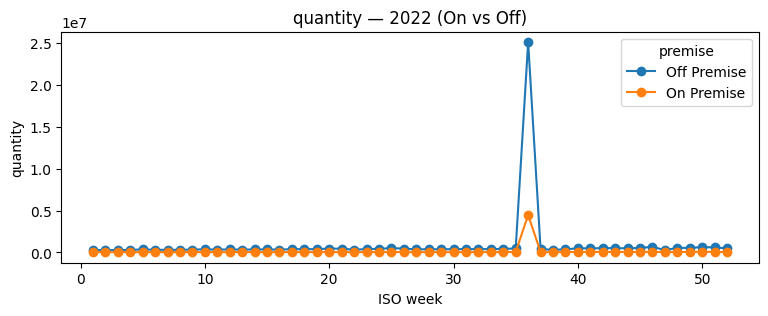

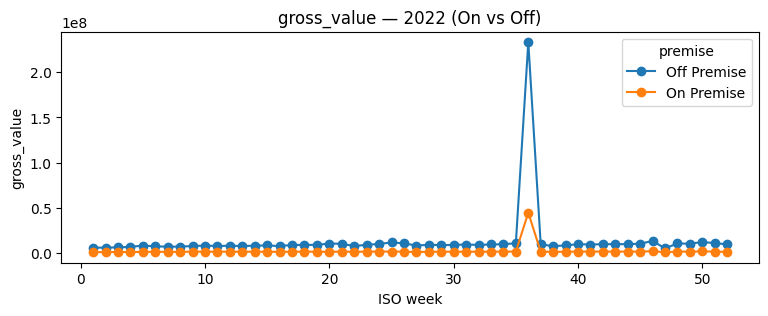

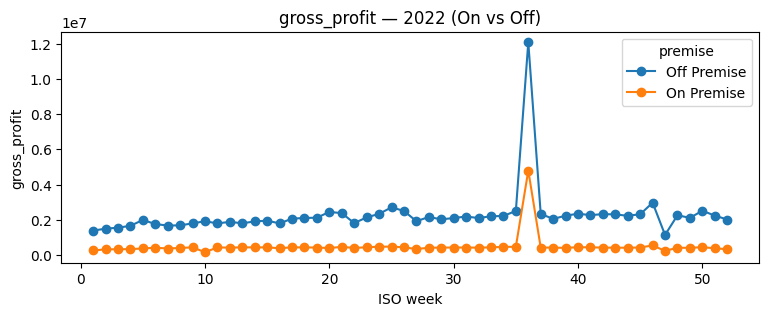

In [13]:
# Série temporal - 2022 - On Premise vs Off Premise (qty, gross_value, gross_profit)

for col in ['quantity','gross_value','gross_profit']:
    ser = (weekly.query('iso_year==2022')
                 .groupby(['iso_week','premise'])[col].sum()
                 .unstack('premise').sort_index())
    ax = ser.plot(figsize=(9,3), marker='o', title=f'{col} — 2022 (On vs Off)')
    ax.set_xlabel('ISO week'); ax.set_ylabel(col); plt.show()

In [ ]:
# PDV×SKU×premise weekly- considerei premise como 2 verticais

weekly = (df_merge.groupby(['premise','pdv','produto','iso_year','iso_week'], as_index=False)
          .agg(quantity=('quantity','sum'),
               gross_value=('gross_value','sum'),
               gross_profit=('gross_profit','sum')))

/var/folders/tt/cg9n1vqn42v1lvq9j7my8_g40000gn/T/ipykernel_2909/80598470.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  weekly = (df_merge.groupby(['premise','pdv','produto','iso_year','iso_week'], as_index=False)


In [14]:
# Dtypes, cardinalidade, null

df_merge.info()
df_merge.nunique()
df_merge.isna().mean().sort_values(ascending=False).head(20)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6560698 entries, 0 to 6560697
Data columns (total 24 columns):
 #   Column            Dtype         
---  ------            -----         
 0   pdv               object        
 1   produto           object        
 2   distributor_id    object        
 3   transaction_date  datetime64[ns]
 4   reference_date    object        
 5   quantity          float32       
 6   gross_value       float32       
 7   net_value         float32       
 8   gross_profit      float32       
 9   discount          float32       
 10  taxes             float32       
 11  produto_prod      object        
 12  categoria         object        
 13  descricao         object        
 14  tipos             object        
 15  label             object        
 16  subcategoria      object        
 17  marca             object        
 18  fabricante        object        
 19  premise           object        
 20  categoria_pdv     object        
 21  zipcode 

label            0.080320
zipcode          0.006948
categoria_pdv    0.006948
premise          0.006948
subcategoria     0.001572
pdv              0.000000
produto          0.000000
iso_year         0.000000
fabricante       0.000000
marca            0.000000
tipos            0.000000
descricao        0.000000
categoria        0.000000
produto_prod     0.000000
taxes            0.000000
discount         0.000000
gross_profit     0.000000
net_value        0.000000
gross_value      0.000000
quantity         0.000000
dtype: float64

In [15]:
dup = weekly.duplicated(['pdv','produto','iso_year','iso_week']).sum()
print(f'duplicatas: {dup}')

duplicatas: 0


In [16]:
### Sanity Check em quantity e price

df_merge['price_per_unit'] = df_merge['net_value']/df_merge['quantity'].replace(0,np.nan)
print((df_merge['quantity']<0).mean(), (df_merge['price_per_unit']<=0).mean())

0.010686972636143289 0.0009049342005987777


1,07% das linhas têm quantity < 0 e 0,09% têm price_per_unit <= 0. Isso é ruído/estorno.

In [17]:
# limpeza

df_merge['price_per_unit'] = df_merge['net_value']/df_merge['quantity'].replace(0,np.nan)
mask_bad = (df_merge['quantity'] <= 0) | (df_merge['price_per_unit'] <= 0)
print({'pct_removido': mask_bad.mean(), 'por_canal': df_merge.loc[mask_bad].groupby('premise').size()/len(df_merge)})
df_merge = df_merge.loc[~mask_bad].copy()

{'pct_removido': 0.02076318708771536, 'por_canal': premise
Off Premise    0.013181
On Premise     0.001566
dtype: float64}


In [18]:
# Reagregando 

weekly = (df_merge.groupby(['premise','pdv','produto','iso_year','iso_week'], as_index=False)
          .agg(quantity=('quantity','sum'),
               gross_value=('gross_value','sum'),
               gross_profit=('gross_profit','sum')))

In [19]:
# anomalias 

flags = mark_week_anomalies(weekly) 
weekly = weekly.merge(flags[flags['premise']!='GLOBAL'],
                      on=['premise','iso_week'], how='left').fillna({'anomaly_flag':False})

In [20]:
# mask somente p/ lags

for c in ['quantity','gross_value','gross_profit']:
    weekly[c+'_lagsrc'] = weekly[c].where(~weekly['anomaly_flag'])

##### Gráficos EDA 

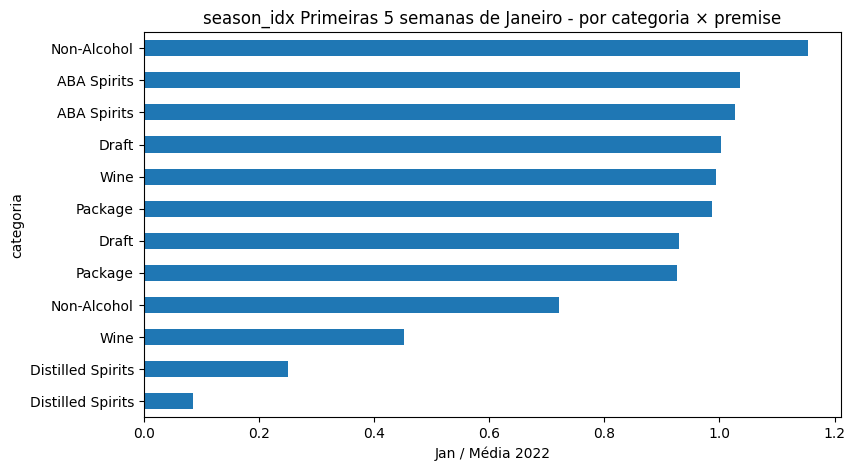

In [21]:
# ===== season_idx 5 semanas de janeiro - por categoria × premise =====
# mapa produto->categoria

prod_cat = (df_merge[['produto','categoria']]
            .dropna().drop_duplicates('produto'))
wcat = weekly.merge(prod_cat, on='produto', how='left')

jan = wcat.query('iso_year==2022 and iso_week<=5')
all22 = wcat.query('iso_year==2022')

base = (all22.groupby(['categoria','premise'])['quantity'].mean()
              .rename('mean_all'))
janm = (jan.groupby(['categoria','premise'])['quantity'].mean()
             .rename('mean_jan'))
season = (pd.concat([base, janm], axis=1)
            .dropna()
            .assign(season_idx=lambda d: d['mean_jan']/d['mean_all'])
            .sort_values('season_idx', ascending=False))

top = season.head(20).reset_index()
ax = top.plot(kind='barh', x='categoria', y='season_idx',
              figsize=(9,5), legend=False, title='season_idx Primeiras 5 semanas de Janeiro - por categoria × premise')
ax.invert_yaxis(); ax.set_xlabel('Jan / Média 2022'); plt.show()

#### Insights 

    •	Non-Alcohol sobre-indexa em janeiro (season_idx > 1). Priorizar cobertura e sortimento nesse par categoria×premise nas 5 primeiras semanas.
    
	•	ABA Spirits ≈ 1. Estável (sem ajuste agressivo).
	•	Draft/Package/Wine ~ 1. Variação pequena, manter baseline.
	•	Distilled Spirits sub-indexa forte (season_idx << 1, alguns pares < 0,3). Reduzir expectativa de demanda e estoque no início do ano.
    
	•	Diferença por Vertical: mesma categoria comporta-se de forma oposta entre premisses (ex.: Non-Alcohol >1 em uma vertical e <1 na outra). Tratar categoria×premise como unidade de sazonalidade.

#### Ações:
	•	Use season_idx como multiplicador nas previsões de jan: yhat *= season_idx(cat,premise).
	•	Para OCO: mais SKUs e nível de serviço em Non-Alcohol na vertical onde >1; racionalizar Distilled Spirits onde <1.
	•	Para PriceO: testar preços/ladders de Non-Alcohol em jan e evitar descontos em Spirits no período de vale.

PDVs para 80% do GP: 3650 de 14403 (25.3%)


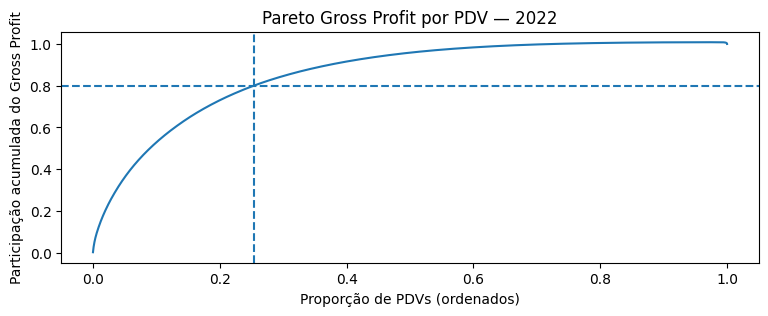

In [24]:
# Pareto 80/20 de Gross Profit por PDV (2022) 

gp = (weekly.query('iso_year==2022')
           .groupby('pdv')['gross_profit'].sum()
           .sort_values(ascending=False))
cum_share = gp.cumsum()/gp.sum()
k80 = int((cum_share<=0.80).sum())
print(f'PDVs para 80% do GP: {k80} de {len(gp)} ({k80/len(gp):.1%})')

x = np.arange(1, len(gp)+1)/len(gp)
plt.figure(figsize=(9,3))
plt.plot(x, cum_share.values)
plt.axhline(0.8, ls='--'); plt.axvline(k80/len(gp), ls='--')
plt.title('Pareto Gross Profit por PDV — 2022')
plt.xlabel('Proporção de PDVs (ordenados)'); plt.ylabel('Participação acumulada do Gross Profit')
plt.show()

##### Insight:
	•	Concentração: ~25% dos PDVs geram 80% do Gross Profit. Cauda longa evidente.

##### Ações práticas:
        
	•	Priorizar cabeça: para WMAPE (micro), foque acurácia em PDVs head. Use validação estratificada por faixa de Gross Profit (head/mid/tail).
	•	OCO: ampliar sortimento e nível de serviço nos PDVs head; racionalizar SKUs na cauda (mínimo catálogo + reposição sob demanda).
	•	PriceO: testar preço/ladder primeiro na cabeça; na cauda, evitar descontos de base, usar promoções táticas.
	•	S&OP: metas via TargAtom por potencial; visitas e estoque focados no quartil top.
	•	Modelagem: modelos/parametrizações distintas
	•	head: lags/rollings densos + sazonalidade;
	•	tail: shrinkage para média de categoria×premise e zero-inflated (muitos zeros).
	•	Métricas operacionais: garantir service_rate_12 alto na cabeça; medir loss under/over por faixa para orientar OCO/PriceO.


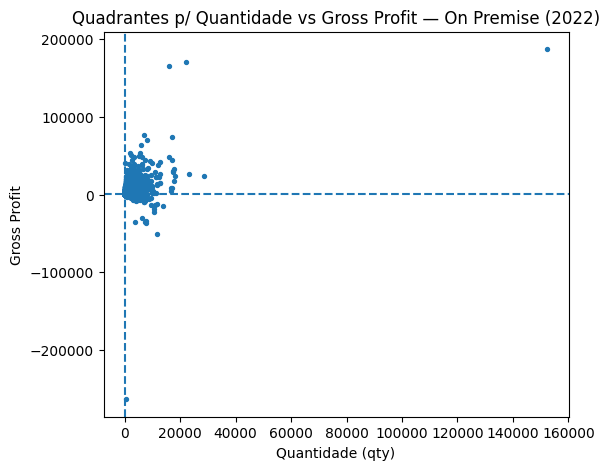

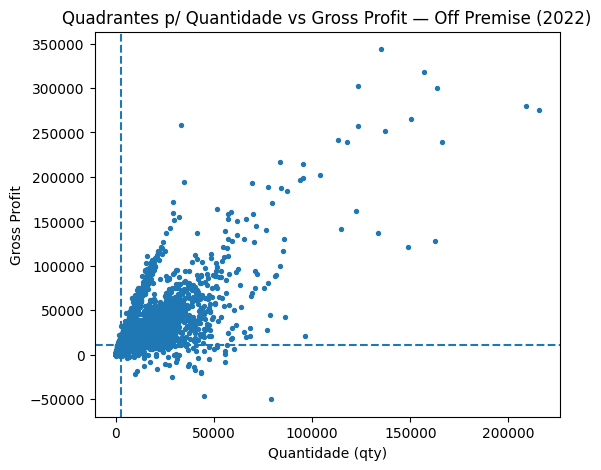

In [28]:
# Quadrantes Quantidade × Gross Profit por vertical (2022) 

for prm in ['On Premise','Off Premise']:
    agg = (weekly.query('iso_year==2022 and premise==@prm')
                 .groupby('pdv')[['quantity','gross_profit']].sum())
    q_med, gp_med = agg['quantity'].median(), agg['gross_profit'].median()
    plt.figure(figsize=(6,5))
    plt.scatter(agg['quantity'], agg['gross_profit'], s=8)
    plt.axvline(q_med, ls='--'); plt.axhline(gp_med, ls='--')
    plt.title(f'Quadrantes p/ Quantidade vs Gross Profit — {prm} (2022)')
    plt.xlabel('Quantidade (qty)'); plt.ylabel('Gross Profit')
    plt.show()

In [29]:
w22 = weekly.query('iso_year==2022')

out = []
for prm in ['On Premise','Off Premise']:
    agg = (w22.query('premise==@prm')
               .groupby('pdv')[['quantity','gross_profit']].sum())
    q_med, gp_med = agg['quantity'].median(), agg['gross_profit'].median()
    def lab(r):
        if r.quantity>=q_med and r.gross_profit>=gp_med: return 'Q1 ↑Quant ↑GP'
        if r.quantity>=q_med and r.gross_profit< gp_med: return 'Q2 ↑Quant ↓GP'
        if r.quantity< q_med and r.gross_profit>=gp_med: return 'Q3 ↓Quant ↑GP'
        return 'Q4 ↓Quant ↓GP'
    agg['quadrante'] = agg.apply(lab, axis=1)
    cnt = agg['quadrante'].value_counts().to_frame(prm)
    out.append(cnt)

quad_counts = pd.concat(out, axis=1).fillna(0).astype(int)
print(quad_counts)

               On Premise  Off Premise
quadrante                             
Q1 ↑Quant ↑GP        3337         2785
Q4 ↓Quant ↓GP        3331         2784
Q2 ↑Quant ↓GP         771          315
Q3 ↓Quant ↑GP         765          315


In [30]:
# contribuição e share de GP por quadrante, por canal
rows = []
for prm in ['On Premise','Off Premise']:
    agg = (w22.query('premise==@prm')
               .groupby('pdv')[['quantity','gross_profit']].sum())
    q_med, gp_med = agg['quantity'].median(), agg['gross_profit'].median()
    def lab(r):
        if r.quantity>=q_med and r.gross_profit>=gp_med: return 'Q1 ↑Quant ↑GP'
        if r.quantity>=q_med and r.gross_profit< gp_med: return 'Q2 ↑Quant ↓GP'
        if r.quantity< q_med and r.gross_profit>=gp_med: return 'Q3 ↓Quant ↑GP'
        return 'Q4 ↓Quant ↓GP'
    agg['quadrante'] = agg.apply(lab, axis=1)
    gp = agg.groupby('quadrante')['gross_profit'].sum().rename(prm)
    rows.append(gp)

gp_by_quad = pd.concat(rows, axis=1).fillna(0)
share_gp = gp_by_quad.div(gp_by_quad.sum())
print(gp_by_quad)
print(share_gp)

                 On Premise   Off Premise
quadrante                                
Q1 ↑Quant ↑GP  2.352744e+07  1.013958e+08
Q2 ↑Quant ↓GP -3.470501e+05  1.643686e+06
Q3 ↓Quant ↑GP  2.018183e+06  4.173738e+06
Q4 ↓Quant ↓GP  1.274841e+06  1.167047e+07
               On Premise  Off Premise
quadrante                             
Q1 ↑Quant ↑GP    0.888719     0.852899
Q2 ↑Quant ↓GP   -0.013109     0.013826
Q3 ↓Quant ↑GP    0.076234     0.035108
Q4 ↓Quant ↓GP    0.048156     0.098167


#### season_idx Jan (categoria×premise)

	•	Insight: Non-Alcohol > 1 em jan (sobre-indexa); Distilled Spirits < 1 (vale).
	•	Efeito no modelo: multiplicador season_idx(cat,premise) nas 5 primeiras semanas.
	•	Ação: ampliar sortimento/nível de serviço em Non-Alcohol; reduzir expectativa e estoque em Spirits no início do ano.

#### Pareto 80/20 (GP por PDV)

	•	Insight: ~25% dos PDVs geram 80% do GP.
	•	Efeito no modelo: validação estratificada (head/mid/tail); otimizar WMAPE micro mirando a cabeça.
	•	Ação: OCO/visitas/estoque priorizados na cabeça; cauda com catálogo mínimo.

#### Quadrantes Quantidade×GP (por canal) — gráfico + tabelas
        
	•	Contagem (seu output): Q1 e Q4 somam ~90% dos PDVs; Q2 e Q3 ~10%.
	•	Share de GP (seu output):
	•	On: Q1 ≈ 88.9% do GP; Q2 negativo; Q3 ≈ 7.6%; Q4 ≈ 4.8%.
	•	Off: Q1 ≈ 85.3%; Q2 ≈ 1.4%; Q3 ≈ 3.5%; Q4 ≈ 9.8%.
	•	Leitura: negócio é bimodal. Q1 concentra GP; Q4 é cauda extensa. Q2 indica problema de margem/preço (On tem GP negativo).
	•	Ações por quadrante:
	•	Q1 ↑Quant ↑GP: proteger estoque, expandir sortimento, SLAs altos.
	•	Q2 ↑Quant ↓GP: PriceO (preço/discount), checar custo-to-serve.
	•	Q3 ↓Quant ↑GP: mix premium, estoque enxuto, metas sob medida.
	•	Q4 ↓Quant ↓GP: racionalizar SKUs/visitas; reposição conservadora.

⸻

#### Insights Gerais

	•	Off Premise puxa nível e GP; janeiro favorece Non-Alcohol; 25% dos PDVs carregam 80% do resultado; Q1 domina o GP nos dois canais.
	•	Decisões de modelagem: sem gross_* contemporâneo, lags/rollings mascarados nas semanas anômalas, season_idx em jan, validação estratificada por head/mid/tail.
	•	Decisões operacionais: OCO e serviço focados em Q1; PriceO para Q2; poda e disciplina na cauda (Q4).

In [33]:
# Reprodutibilidade 

import os, json, hashlib, numpy as np, pandas as pd
SNAP = "artifacts/run_2025_01"   # mude o nome 1x e não troque mais
os.makedirs(SNAP, exist_ok=True)

SEED = 42
np.random.seed(SEED)

# hashes para garantir imutabilidade
def md5_df(df): return hashlib.md5(pd.util.hash_pandas_object(df, index=True).values).hexdigest()

# salve *já limpo* e agregações estáveis
df_merge.to_parquet(f"{SNAP}/df_merge_clean.parquet", index=False)
weekly.to_parquet(  f"{SNAP}/weekly.parquet",        index=False)
flags.to_parquet(   f"{SNAP}/anomaly_flags.parquet", index=False)
season.to_csv(      f"{SNAP}/season_idx.csv",        index=False)

meta = {
  "seed": SEED,
  "hash_df_merge": md5_df(df_merge),
  "hash_weekly":   md5_df(weekly),
  "hash_flags":    md5_df(flags)
}
json.dump(meta, open(f"{SNAP}/meta.json","w"), indent=2)